# Proyecto de identificación de especies de tiburón mediante Deep learning

### Cada apartado de código incluye una explicación previa de lo que se va a hacer en la celda siguiente

Importamos las librerias necesarias para el proyecto, se van añadiendo conforme hacen falta en el mismo.


In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2 as cv

import tensorflow as tf

from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPool2D,Dropout

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix

import seaborn as sns

### Preparación de las imagenes

Definimos los set de fotos de train y test

In [2]:
TRAIN_PATH = "./data/tibu_train"
TEST_PATH = "./data/tibu_test"

Definimos las etiquetas y tamaño de imagen para el modelo

In [3]:
class_names = ['Tiburon azul o Tintorera (Prionace glauca)',
               'Tiburon ballena (Rhincodon typus)',
               'Tiburon blanco (Carcharodon carcharias)',
               'Tiburon lamia (Carcharhinus leucas)',
               'Tiburon limon (Negaprion brevirostris)',
               'Tiburon mako o Marrajo (Isurus oxyrinchus)',
               'Tiburon martillo (Sphyrna mokarran)',
               'Tiburon nodriza (Ginglymostoma cirratum)',
               'Tiburon peregrino (Cethorhinus maximus)',
               'Tiburon punta blanca oceanico (Carcharhinus longimanus)',
               'Tiburon punta negra (Carcharhinus limbatus)',
               'Tiburon tigre (Galeocerdo cuvier)',
               'Tiburon toro (Carcharias taurus)',
               'Tiburon zorro (Alopias vulpinus)']

IMAGE_SIZE = (250,250)

Le damos un Valor a cada etiqueta

In [4]:
class_names_label = {class_name:i for i ,class_name in enumerate(class_names)}
class_names_label

{'Tiburon azul o Tintorera (Prionace glauca)': 0,
 'Tiburon ballena (Rhincodon typus)': 1,
 'Tiburon blanco (Carcharodon carcharias)': 2,
 'Tiburon lamia (Carcharhinus leucas)': 3,
 'Tiburon limon (Negaprion brevirostris)': 4,
 'Tiburon mako o Marrajo (Isurus oxyrinchus)': 5,
 'Tiburon martillo (Sphyrna mokarran)': 6,
 'Tiburon nodriza (Ginglymostoma cirratum)': 7,
 'Tiburon peregrino (Cethorhinus maximus)': 8,
 'Tiburon punta blanca oceanico (Carcharhinus longimanus)': 9,
 'Tiburon punta negra (Carcharhinus limbatus)': 10,
 'Tiburon tigre (Galeocerdo cuvier)': 11,
 'Tiburon toro (Carcharias taurus)': 12,
 'Tiburon zorro (Alopias vulpinus)': 13}

Creamos el set de imagenes, uniendo cada foto de cada carpeta con su respectiva etiqueta y se preparan para el modelo cambiando el color, tamaño y añadiendo el filtro para resaltar los bordes.

In [5]:

def read_data(path, im_size, class_names_label):
    X = []
    y = []

    for folder in os.listdir(path):
        label = class_names_label[folder]
        folder_path = os.path.join(path, folder)
       
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            image = cv.imread(image_path)
            
            if image is not None:
                print(f"Image path: {image_path}")
                print(f"Image shape before resize: {image.shape}")
                
                image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
                image = cv.resize(image, im_size)
                image = cv.Canny(image, 125, 175)
                X.append(image)
                y.append(label)
            else:
                print(f"Error al leer la imagen: {image_path}")
    
    
    return np.array(X), np.array(y)
    


X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE, class_names_label)
X_test, y_test = read_data(TEST_PATH, IMAGE_SIZE, class_names_label)

print(X_train.shape)
print(X_test.shape)

Image path: ./data/tibu_train\Tiburon azul o Tintorera (Prionace glauca)\00000000.jpg
Image shape before resize: (800, 1200, 3)
Image path: ./data/tibu_train\Tiburon azul o Tintorera (Prionace glauca)\00000001.jpg
Image shape before resize: (2667, 4000, 3)
Image path: ./data/tibu_train\Tiburon azul o Tintorera (Prionace glauca)\00000002.jpg
Image shape before resize: (758, 1200, 3)
Image path: ./data/tibu_train\Tiburon azul o Tintorera (Prionace glauca)\00000003.jpg
Image shape before resize: (1667, 2500, 3)
Image path: ./data/tibu_train\Tiburon azul o Tintorera (Prionace glauca)\00000004.jpg
Image shape before resize: (363, 622, 3)
Image path: ./data/tibu_train\Tiburon azul o Tintorera (Prionace glauca)\00000005.jpg
Image shape before resize: (1024, 1536, 3)
Image path: ./data/tibu_train\Tiburon azul o Tintorera (Prionace glauca)\00000006.jpg
Image shape before resize: (733, 1100, 3)
Image path: ./data/tibu_train\Tiburon azul o Tintorera (Prionace glauca)\00000007.jpg
Image shape befo

Comprobamos el shape de las imagenes

In [6]:
print(y_train.shape)
print(y_test.shape)

(1520,)
(384,)


Comprobamos las etiquetas y vemos que al venir de carpetas estan ordenadas

In [7]:
y_train

array([ 0,  0,  0, ..., 13, 13, 13])

mezclamos imagenes y etiquetas de entrenamiento

In [8]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

comprobamos cuantas imagenes teneos por clase

In [9]:
pd.DataFrame(y_train).value_counts()

2     134
1     130
6     127
9     122
13    118
10    114
0     107
4     105
3     102
5     101
11     97
12     97
8      93
7      73
Name: count, dtype: int64

imprimimos una imagen en pantalla para comprobarque la etiqueta e imagen esten bien

Tiburon ballena (Rhincodon typus)


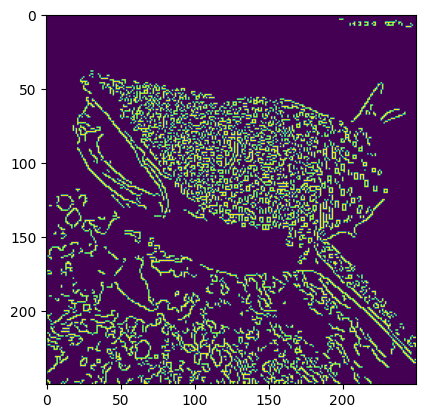

In [11]:
index = np.random.randint(X_train.shape[0])
print(class_names[y_train[index]])
plt.imshow(X_train[index]);

### Preparación del modelo y entrenamiento

Preparamos un modelo secuencial propio

In [15]:

model = Sequential()

model.add(Conv2D(filters= 64, kernel_size= 3, strides= (1,1), activation= 'relu', padding= 'same', input_shape= (250,250,1))) 
model.add(MaxPool2D()) 
model.add(Dropout(0.2)) 

model.add(Conv2D(filters= 64, kernel_size= 3, strides= (1,1), activation= 'relu', padding= 'same'))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D(filters= 64, kernel_size= 3, strides= (1,1), activation= 'relu', padding= 'same'))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(180, activation='relu'))
model.add(Dense(100, activation='relu'))

model.add(Dense(14, activation='softmax'))

Observamos el tamaño del modelo

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 125, 125, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

Modificamos el learning rate para que los saltos sean mas pequeños y poder afinar mas

In [17]:

optimizer=Adam(learning_rate=0.00001)

Compilamos el modelo introduciendo el optimizador modificado

In [18]:
model.compile(optimizer= optimizer, loss= "sparse_categorical_crossentropy", metrics=['accuracy'])

Definimos e introducimos dos callbacks en el fit, el primero para que el modelo pare si el Val_loss no mejora en 5 epocas y el segundo para que guarde automaticamente el mejor modelo.

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath='mi_mejor_modelo_line2.h5', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=10, epochs=50, validation_split=0.1, callbacks=[early_stopping, checkpoint])

Epoch 1/50


137/137 [==============================] - ETA: 0s - loss: 11.8907 - accuracy: 0.0958

c:\Users\funny\anaconda3\envs\deepln_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - 59s 418ms/step - loss: 11.8907 - accuracy: 0.0958 - val_loss: 4.2425 - val_accuracy: 0.1250
Epoch 2/50
137/137 [==============================] - 56s 409ms/step - loss: 5.1074 - accuracy: 0.1075 - val_loss: 3.1031 - val_accuracy: 0.0724
Epoch 3/50
137/137 [==============================] - 59s 430ms/step - loss: 3.4423 - accuracy: 0.1257 - val_loss: 2.7601 - val_accuracy: 0.0658
Epoch 4/50
137/137 [==============================] - 58s 420ms/step - loss: 2.7899 - accuracy: 0.1323 - val_loss: 2.7097 - val_accuracy: 0.0658
Epoch 5/50
137/137 [==============================] - 57s 413ms/step - loss: 2.6847 - accuracy: 0.1330 - val_loss: 2.6824 - val_accuracy: 0.0789
Epoch 6/50
137/137 [==============================] - 56s 407ms/step - loss: 2.5852 - accuracy: 0.1506 - val_loss: 2.6678 - val_accuracy: 0.0789
Epoch 7/50
137/137 [==============================] - 55s 398ms/step - loss: 2.5328 - accuracy: 0.1674 - val_loss: 2.6684 - val_accuracy: 0.

Guardamos el modelo final

In [20]:
model.save("my_keras_model_line2.h5")

Hacemos un df con el historico del modelo

In [21]:
df_hist = pd.DataFrame(history.history)
df_hist

,loss,accuracy,val_loss,val_accuracy
0,11.890733,0.095760,4.242463,0.125000
1,5.107396,0.107456,3.103082,0.072368
2,3.442284,0.125731,2.760148,0.065789
3,2.789891,0.132310,2.709676,0.065789
4,2.684663,0.133041,2.682413,0.078947
5,2.585188,0.150585,2.667770,0.078947
6,2.532761,0.167398,2.668430,0.098684
7,2.494391,0.174708,2.647295,0.092105
8,2.415910,0.190789,2.694034,0.072368
9,2.390072,0.206871,2.646675,0.092105


Hacemos una grafica que enfrente el entrenamiento con la validacion para ver si tenemos mucho overfitting

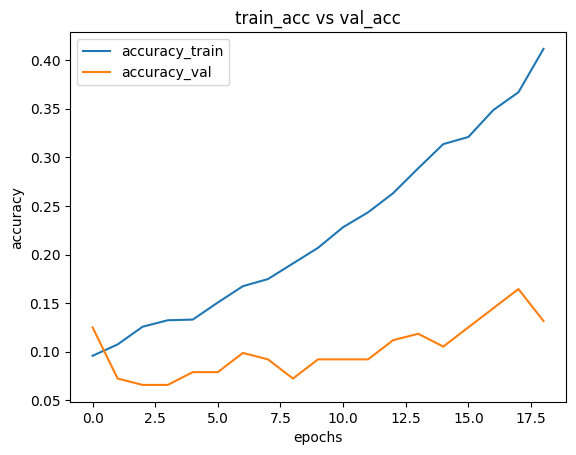

In [22]:
plt.figure()
plt.plot(df_hist['accuracy'], label="accuracy_train")
plt.plot(df_hist['val_accuracy'], label="accuracy_val")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

Cargamos el modelo que hemos guardado como mejor modelo

In [30]:
new_model = tf.keras.models.load_model('mi_mejor_modelo_line2.h5')

Comprobamos ambos modelos, el mejor y el final con las imagenes de test para ver el Accuracy

In [31]:
new_model.evaluate(X_test, y_test)

12/12 [==============================] - 3s 210ms/step - loss: 2.4272 - accuracy: 0.2422


[2.4272472858428955, 0.2421875]

In [27]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 3s 211ms/step - loss: 2.4759 - accuracy: 0.2344


[2.4758846759796143, 0.234375]

Realizamos una prediccion con el test

In [25]:
prediction= new_model.predict(X_test)

12/12 [==============================] - 3s 212ms/step


Trasnsformamos las probabilidades de prediccion en las etiquetas mas probables

In [26]:
prediction=np.argmax(new_model.predict(X_test),axis=1)
prediction

12/12 [==============================] - 3s 216ms/step


array([ 0,  0,  0,  0, 10, 13, 12,  5, 13,  2,  1, 13, 12,  1,  9,  5, 13,
       12,  9, 13, 13,  5,  1, 13,  9, 13,  2, 13,  2,  9,  8,  1, 13,  0,
        9,  1,  8,  8, 13, 10,  4,  9,  2,  8,  9,  6,  1,  5,  8,  9,  9,
       12,  3,  1, 12,  1,  2,  9,  9, 13, 13,  2, 12, 12,  9,  2, 12,  2,
       13,  9,  5, 13,  3,  1, 12, 12, 11,  3, 13,  9,  9,  6, 13,  9,  2,
        9, 13,  4, 10,  8, 13, 12, 12,  3,  4,  4,  3, 13,  3, 12,  7, 12,
       13,  6, 13,  8,  9,  0, 12, 12,  9, 13,  0,  2, 13, 13, 12,  0,  8,
        1, 10,  2, 13,  9,  9,  9, 13, 13,  9,  3,  5, 13, 12, 13,  1, 13,
       12,  8, 13, 13,  8, 13, 11, 11,  9,  9, 12,  2,  9, 13,  9,  7, 13,
        7, 13, 13, 10,  9, 12,  0,  9,  4,  9,  9,  7,  7, 13, 13,  0, 11,
       12,  7,  9, 10,  2,  7, 13, 13, 10, 13, 12, 13, 13,  9,  7, 12,  9,
        8,  8, 13,  9,  9,  9, 13,  9,  0, 13,  1, 13,  9, 12, 11,  9,  9,
       13, 13,  9,  9,  1,  9,  9,  8, 12, 13, 13,  6, 12, 13, 12, 13,  9,
        9, 10,  7, 10, 10

Realizamos una matriz de confusion para observar donde ha acertado mas el modelo

In [27]:
cm= confusion_matrix(y_test,prediction)
cm

array([[ 4,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  0,  1,  2],
       [ 1,  8,  4,  1,  1,  3,  1,  0,  5,  9,  1,  0,  4,  9],
       [ 0,  1,  4,  2,  0,  1,  1,  0,  0,  8,  0,  1,  5,  7],
       [ 0,  0,  0,  1,  1,  0,  0,  0,  1,  0,  1,  0,  2,  1],
       [ 1,  0,  0,  2,  2,  0,  1,  1,  1,  1,  0,  0,  2,  3],
       [ 2,  2,  2,  1,  0,  1,  0,  0,  1,  5,  1,  0,  4,  8],
       [ 1,  0,  1,  0,  0,  0,  0,  2,  2,  5,  1,  2,  3,  8],
       [ 1,  0,  1,  0,  1,  0,  0,  5,  0,  6,  2,  1,  3,  7],
       [ 1,  2,  0,  0,  0,  0,  0,  0,  3, 11,  0,  1,  1,  6],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  2,  0,  0,  3,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  7,  1,  1,  0],
       [ 1,  0,  1,  2,  1,  0,  3,  6,  0,  6,  1,  6,  6,  9],
       [ 0,  1,  3,  0,  2,  1,  1,  1,  0,  4,  0,  0,  6, 10],
       [ 2,  0,  2,  7,  1,  1,  1,  2,  2,  3,  1,  6,  8, 44]],
      dtype=int64)

Definimos etiquetas para poner en los ejes del heatmap

In [28]:
class_shrk = ['Tiburon azul o Tintorera',
               'Tiburon ballena',
               'Tiburon blanco',
               'Tiburon lamia',
               'Tiburon limon',
               'Tiburon mako o Marrajo',
               'Tiburon martillo',
               'Tiburon nodriza',
               'Tiburon peregrino',
               'Tiburon punta blanca oceanico',
               'Tiburon punta negra',
               'Tiburon tigre',
               'Tiburon toro',
               'Tiburon zorro']

Representamos la matriz de confusion en un heatmap

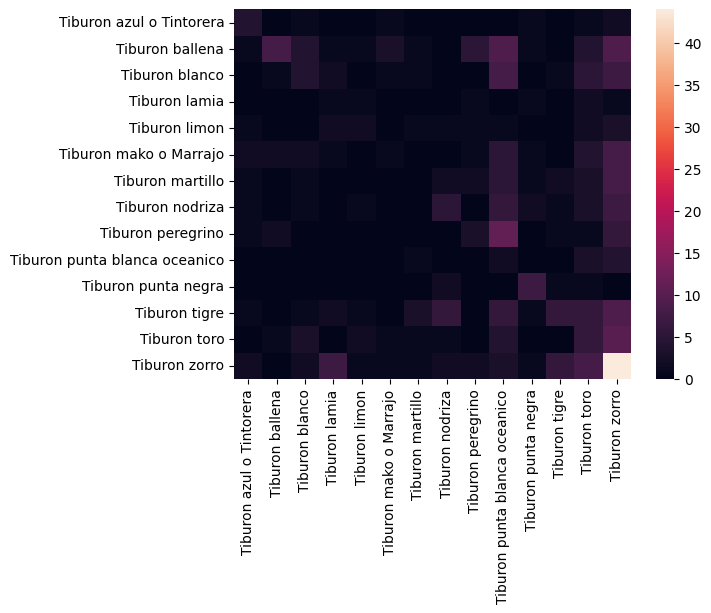

In [29]:
sns.heatmap(cm,xticklabels=class_shrk,yticklabels=class_shrk);